In [10]:
import numpy as np
import numpy.random as nrand
import pandas as pd
import pickle
import copy
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
import uncertainties as unc
import uncertainties.unumpy as unp

In [16]:
landscape_dict = {'trna':{}}
for model in ['trna']:
    for metric in ['N_Max','epi','r_s','open_ratio']:
        with open(f'trna_raw_data/{model}_{metric}_plot.pkl','rb') as f:
            landscape_dict[model][metric] = pickle.load(f)

In [17]:
ylim_dict =  {
    'trna':{'N_Max':[2400,2900],'epi':[0.07,0.11],'r_s':[1.5,4],'open_ratio':[0.1,0.4]}
}

In [18]:
# Holling type III functional response model.

def func(x, a, b, c):
    return a*x**2/(a*b*x**2+1)+c

def cal_slope(x,a,b,c):
    x1 = x
    y1 = func(x,a,b,c)
    slope = a*b*np.exp(b*x)
    x0 = 0
    y0 = y1 - x*slope
    return x0,x1,y0,y1

In [19]:
def SSE(popt):
    return sum((func(np.array([1/np.sqrt(i) for i in range(1,7)]), *popt)-\
                np.array([np.mean(r_s_dict[i]) for i in range(1,7)]))**2)

In [20]:
ruggedness_measure_dict = {'N_Max':'$N_{max}$','epi':'$F_{rse}$','r_s':'$r/s$','open_ratio':'$F_{bp}$'}

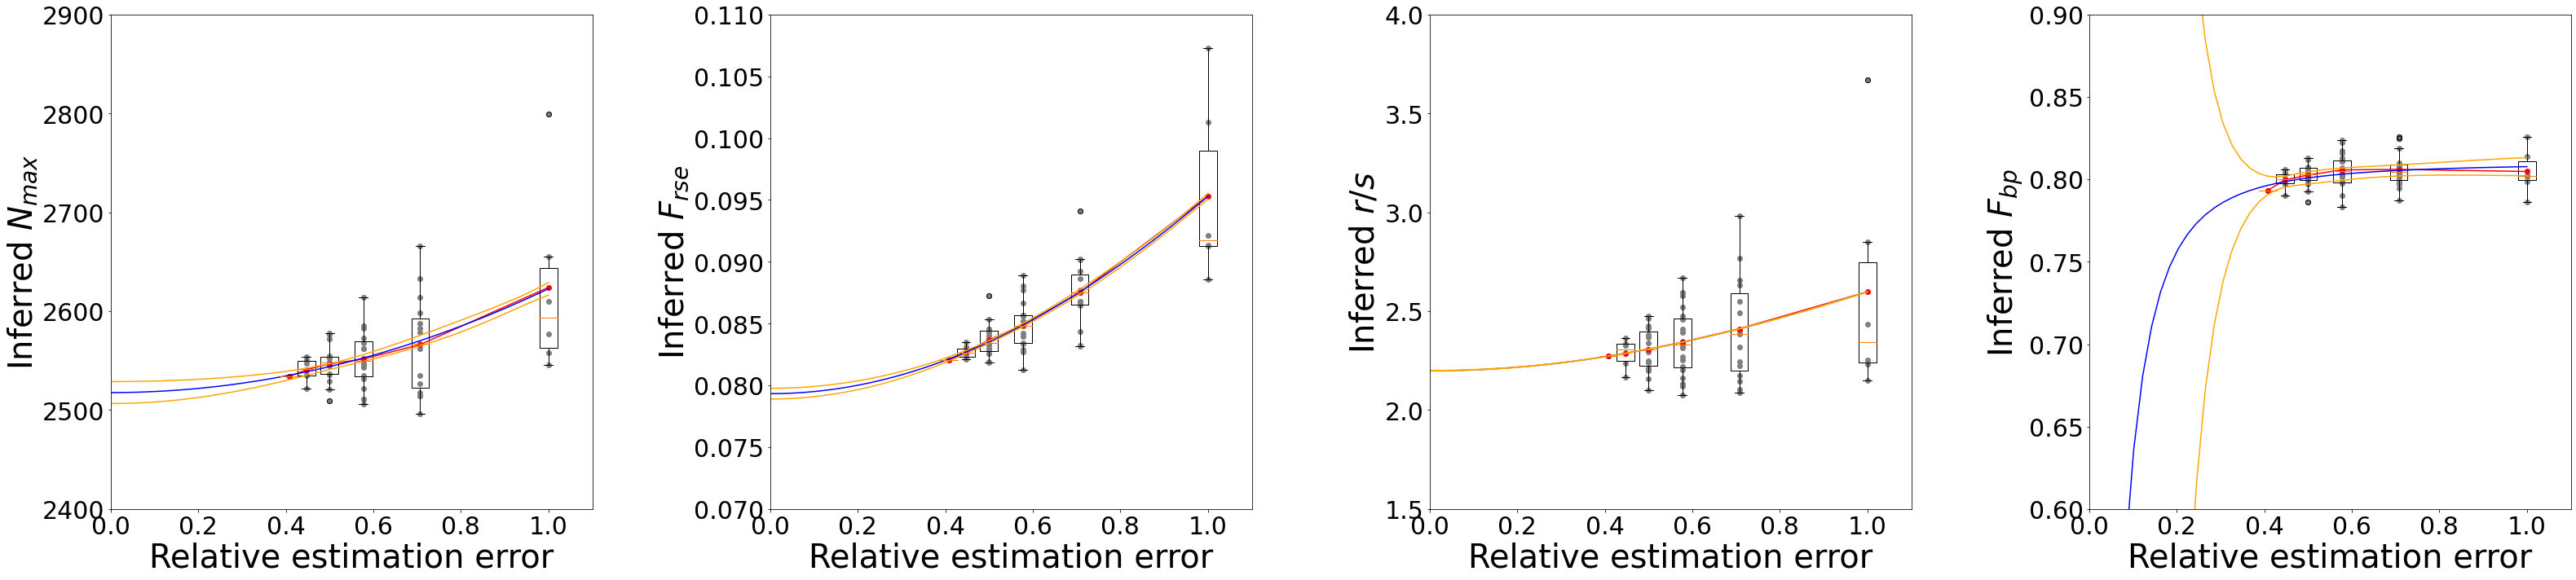

In [21]:
figure,axes = plt.subplots(1,4,figsize=[44,10])

for row,model in enumerate(['trna']):
    measurement_std = measurement_std_dict[model]
    for column,metric in enumerate(['N_Max','epi','r_s','open_ratio']):
        ax = axes[column]
        
        if metric == 'open_ratio':
            r_s_dict = {}
            for i in range(1,7):
                r_s_dict[i] = [1-k for k in landscape_dict[model][metric][i]]
        else:
            r_s_dict = landscape_dict[model][metric]

        # fit curve
        xdata = [1/np.sqrt(i) for i in range(1,7)]
        ydata = [np.mean(r_s_dict[i]) for i in range(1,7)]

        popt_1, pcov_1 = curve_fit(func, xdata, ydata,maxfev=10000,bounds=([0,0,0],[np.inf,np.inf,np.inf]))
        popt_2, pcov_2 = curve_fit(func, xdata, ydata,maxfev=100000,bounds=([-np.inf,-np.inf,0],[0,0,np.inf]))
        if SSE(popt_1) < SSE(popt_2):
            popt = popt_1
            pcov = pcov_1
        else:
            popt = popt_2
            pcov = pcov_2
        
        # draw boxplot, dots, link line 
        for i in range(1,7):
            ax.scatter(x=[1/np.sqrt(i)]*len(r_s_dict[i]),y=r_s_dict[i],color="grey")
        ax.boxplot([r_s_dict[i] for i in range(1,7)],positions = [1/np.sqrt(i) for i in range(1,7)],widths=0.04)
        ax.plot([1/np.sqrt(i) for i in range(1,7)],[np.mean(r_s_dict[i]) for i in range(1,7)],'ro-')
        
        # set pyplot parameters
        if model != 'trna':
            ax.set_ylim(ylim_dict['Theoretical'][metric])
        else:
            if metric == 'open_ratio':
                ax.set_ylim([1-ylim_dict['trna'][metric][1],1-ylim_dict['trna'][metric][0]])
            else:
                ax.set_ylim(ylim_dict['trna'][metric])
        
        ax.set_xlim(0,1.1)
        ax.set_xticks(np.arange(0, 1.2, 0.2))
        ax.xaxis.set_tick_params(labelsize=30)
        ax.yaxis.set_tick_params(labelsize=30)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        ax.set_xlabel(f'Relative estimation error',fontsize=40)
        ax.set_ylabel(f'Inferred {ruggedness_measure_dict[metric]}',fontsize=40)
        
        # draw fitted curve
        ax.plot(np.linspace(0,1,50), func(np.linspace(0,1,50), *popt),
                 'b-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
        
        # draw confidence bounds
        px = np.linspace(0,1,50)
        py = func(px, *unc.correlated_values(popt,pcov))
        nom = unp.nominal_values(py)
        std = unp.std_devs(py)
        
        ax.plot(np.linspace(0,1,50), nom+std*1.96,
                color='orange',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

        ax.plot(np.linspace(0,1,50), nom-std*1.96,
                color='orange',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.tight_layout(w_pad=8)
